In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

path = './input/'

data = pd.read_csv(path + 'train.csv')
data.shape

(891, 12)

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


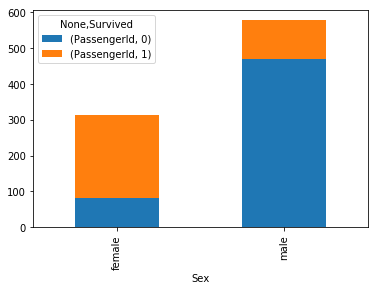

In [3]:
data[['PassengerId','Survived','Sex']].groupby(['Sex', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#Most females survived while most males died. Correlation?

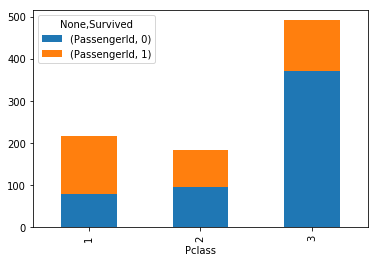

In [4]:
data[['PassengerId','Survived','Pclass']].groupby(['Pclass', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#People in higher classes survived more. Correlation?

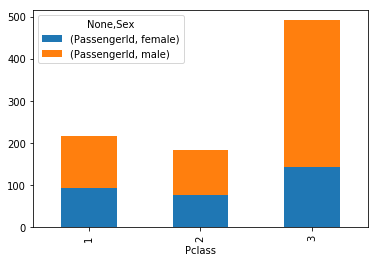

In [5]:
data[['PassengerId','Sex','Pclass']].groupby(['Pclass', 'Sex']).count().unstack().plot(kind='bar', stacked=True)

#More females in higher classes (1 and 2). What can we conclude? 
#Did females survive more because they were wealthy?
#Did wealthier people survive more because they had a high ratio of females?

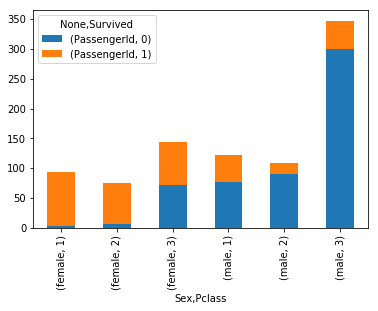

In [6]:
data[['PassengerId','Survived','Sex','Pclass']].groupby(['Sex', 'Pclass', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#Class does seem to affect the survival rate

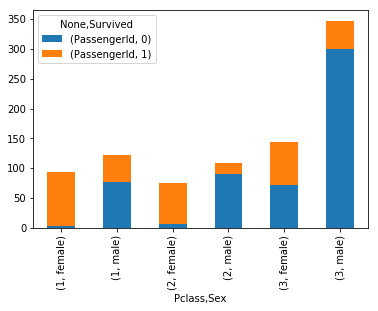

In [7]:
data[['PassengerId','Survived','Sex','Pclass']].groupby(['Pclass', 'Sex', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#Gender also seems to affect the survival rate

In [8]:
#Let's see if we have any missing values in our data

col_na = []
nb_na = np.zeros(data.shape[1])
for i in range(data.shape[1]):
    col_na.append(data.columns[i])
    nb_na[i] = data.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

#We need to find a way to fill Age, Cabin and Embarked

,0
0.0,PassengerId
0.0,Survived
0.0,Pclass
0.0,Name
0.0,Sex
177.0,Age
0.0,SibSp
0.0,Parch
0.0,Ticket
0.0,Fare


In [9]:
#Filling missing Embarked values
#If we can find another passanger with the same ticket, we can use their Embarked value to fill the NA

missing_emb = data.index[data['Embarked'].isna()].tolist()
ticket = np.zeros(len(missing_emb))

for i in range(len(missing_emb)):
    for j in range(891):
        if(j != missing_emb[i] and data.loc[j, 'Ticket'] == data.loc[missing_emb[i], 'Ticket']):
            ticket[i] = data.loc[j, 'Ticket']

ticket

array([113572., 113572.])

In [10]:
data.index[data['Ticket'] == ticket[0]].tolist()

[]

In [11]:
#No one else has the same ticket, so the second best option is probably to fill the column
#with the most common value

data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

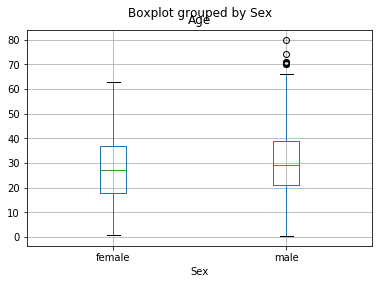

In [12]:
### To fill missing age, we can look for a relationship with other variables

data.boxplot('Age', by='Sex')

#Age is distributed differently for males and females

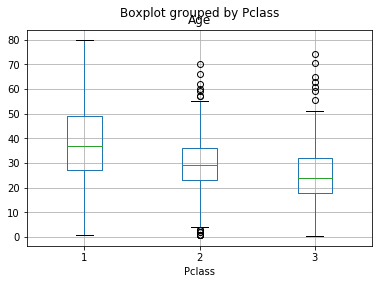

In [13]:
data.boxplot('Age', by='Pclass')

#Age is distributed even more differently depending on class

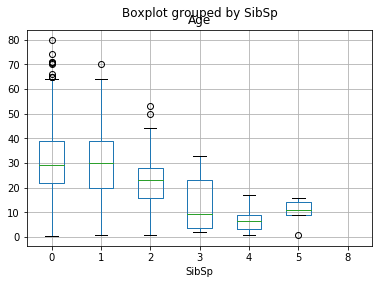

In [14]:
data.boxplot('Age', by='SibSp')

#Someone with a SibSp higher than 2 is travelling with siblings,
#it's more likely to be someone young travelling with their family

In [15]:
data.replace('male', 0, inplace=True)
data.replace('female', 1, inplace=True)
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",0,32.0,0,0,370376,7.75,NaN,Q


In [16]:
#We can try to fill the missing age values thanks to class and gender, using KNN

reg = KNeighborsRegressor(n_neighbors=5)
data_age = (data.loc[data['Age'].isna() == False]).iloc[:,[2,4,5,6]]
X_age = data_age[['Pclass', 'Sex', 'SibSp']]
y_age = data_age['Age']
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, test_size=0.33)
reg.fit(X_age_train, y_age_train)
pred_age = reg.predict((data.loc[data['Age'].isna() == True]).iloc[:,[2,4,6]])
reg.score(X_age_test, y_age_test)

0.1384872409812018

In [17]:
i = 0
for j in range(891):
    if(np.isnan(data.loc[j, 'Age'])):
        data.loc[j, 'Age'] = pred_age[i]
        i += 1
        
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,26.5,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",0,32.0,0,0,370376,7.75,NaN,Q


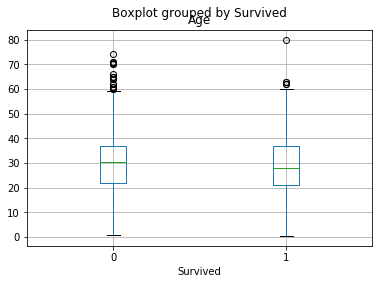

In [18]:
data.boxplot('Age', by='Survived')

In [19]:
### Missing values for cabin

data[['PassengerId', 'Pclass']].where(data['Cabin'].isna()).groupby(['Pclass']).count()

,PassengerId
Pclass,
1.0,40
2.0,168
3.0,479


In [20]:
data[['PassengerId', 'Pclass']].groupby(['Pclass']).count()

#Cabin seems to only be interesting for passengers of the class 1, which are a minority

,PassengerId
Pclass,
1,216
2,184
3,491


In [21]:
#location = []
#for i in range(891):
#    if(isinstance(data.loc[i, 'Cabin'], str)):
#        location.append(data.loc[i, 'Cabin'][0])
#    else:
#        location.append(np.nan)
#data['Location'] = location

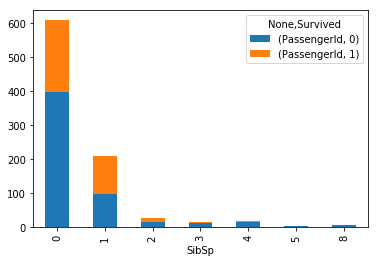

In [22]:
### Let's see if big families tend to survive more or less, or if it doesn't affect the survival
#Maybe families were given priority, or maybe having too many family members hindered the survival

df_sibsp = data[['PassengerId','Survived','SibSp']].groupby(['SibSp', 'Survived']).count()
df_sibsp.unstack().plot(kind='bar', stacked=True)

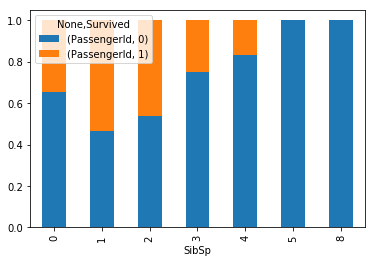

In [23]:
def ratio(df, both = [], only_0 = [], only_1 = []):
    df.loc[:,'PassengerId'] = df.loc[:, 'PassengerId'].astype(float)
    for i in both:
        total = df.loc[(i,0),] + df.loc[(i,1),]
        df.loc[(i,0),] = df.loc[(i,0),]/total
        df.loc[(i,1),] = df.loc[(i,1),]/total
        total = 0
    for j in only_0:
        df.loc[(j,0),] = 1
    for k in only_1:
        df.loc[(j,1),] = 1
    return df

ratio(df_sibsp, range(5), [5,8]).unstack().plot(kind='bar', stacked=True)

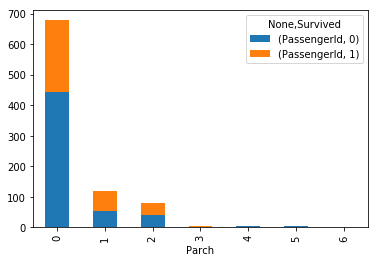

In [24]:
df_parch = data[['PassengerId','Survived','Parch']].groupby(['Parch', 'Survived']).count()
df_parch.unstack().plot(kind='bar', stacked=True)

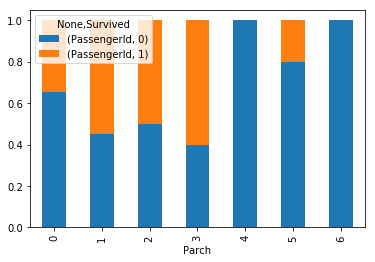

In [25]:
ratio(df_parch, [0,1,2,3,5], [4,6]).unstack().plot(kind='bar', stacked=True)

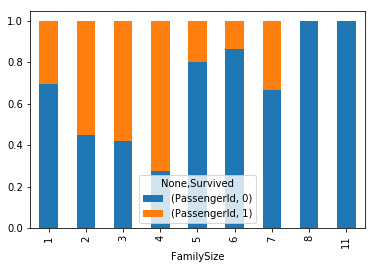

In [26]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
df_famsize = data[['PassengerId','Survived','FamilySize']].groupby(['FamilySize', 'Survived']).count()
ratio(df_famsize, range(1,8), [8,11]).unstack().plot(kind='bar', stacked=True)

#We notice that small families have a higher survival rate, 
#while people who are alone or in a big family have a lower survival rate

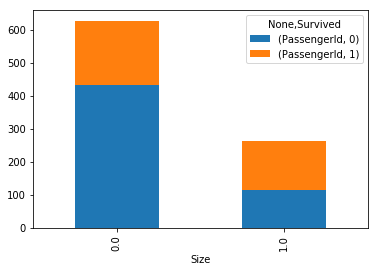

In [27]:
#Thus, it'd be more interesting to replace the quantitative FamilySize by a categorical value
#which would take value 0 if FamilySize(=1 or >4)
#and would take value 1 if 1<FamilySize<5

size = np.zeros(891)
for i in range(891):
    if(data.loc[i, 'FamilySize'] > 1 and data.loc[i, 'FamilySize'] < 4):
        size[i] = 1
data['Size'] = size

data[['PassengerId','Survived','Size']].groupby(['Size', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

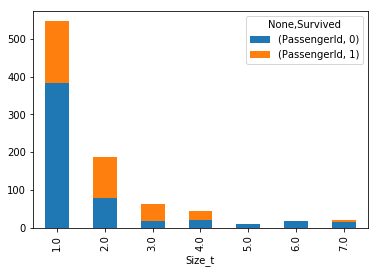

In [28]:
#There's another way to evaluate a travelling group's size, even if they're not a family
#People travelling together are more likely to have bought the ticket together

ticket_count = data['Ticket'].value_counts()
data_ticket = pd.DataFrame(data={'ticket' : ticket_count.index.values, 'count' : ticket_count.values})

size_t = np.zeros(891)
for i in range(891):
    idx = data_ticket.index[data_ticket['ticket'] == data.loc[i, 'Ticket']].tolist()[0]
    size_t[i] = data_ticket.loc[idx, 'count']
data['Size_t'] = size_t

df_size_t = data[['PassengerId','Survived','Size_t']].groupby(['Size_t', 'Survived']).count()
df_size_t.unstack().plot(kind='bar', stacked=True)

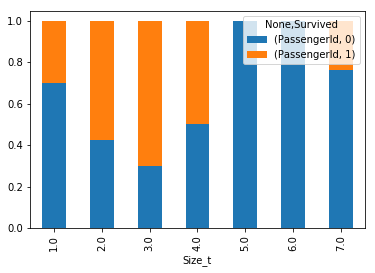

In [29]:
ratio(df_size_t, [1,2,3,4,7], [5,6]).unstack().plot(kind='bar', stacked=True)

#For this feature as well, a size between 2 and 4 is linked to a bigger chance of survival,
#Therefore using it would be redundant

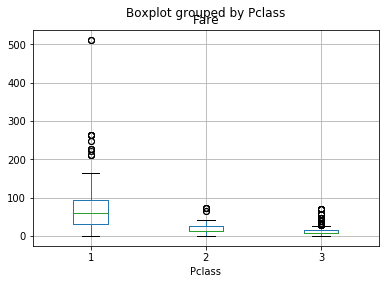

In [30]:
data.boxplot('Fare', by='Pclass')

#The ticket fare seems to be highly correlated to the class.

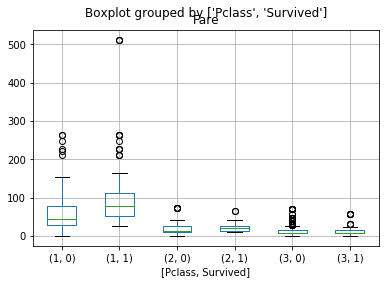

In [31]:
data.boxplot('Fare', by=['Pclass', 'Survived'])

#In the same class, a difference of ticket fare only seems to affect the survival rate for class 1
#In any case, rich people are more likely to survive 

#Conclusion : Keep or drop Fare/Pclass? Any new feature to extract?

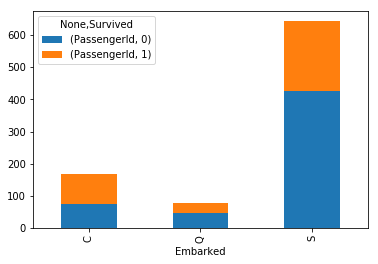

In [32]:
df_emb = data[['PassengerId','Survived','Embarked']].groupby(['Embarked', 'Survived']).count()
df_emb.unstack().plot(kind='bar', stacked=True)

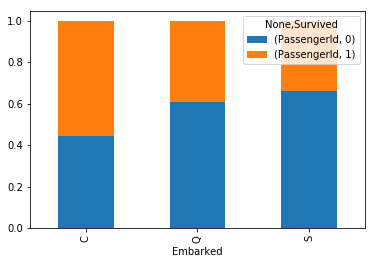

In [33]:
ratio(df_emb, ['C', 'Q', 'S']).unstack().plot(kind='bar', stacked=True)

#It seems like for people who embarked at port C, the chance of survival is higher than for people
#who embarked at ports Q and S

In [34]:
#We can replace this feature with a 0 for ports Q and S, and 1 for port C

data.replace('C', 1, inplace=True)
data.replace('Q', 0, inplace=True)
data.replace('S', 0, inplace=True)

In [35]:
### This should be the final line of code
### It generates a clean csv to be used for training our models

data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Size', 'Embarked']].to_csv('./cleanData/train.csv')